## Multinomial Logistic Regression (Softmax Regression)

This is my attempt to implement Softmax Regression using Python3 and Numpy. I was inspired to think about machine learning problems and their implimentations after having taken [Andrew Ng's Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning). Most of the ideas  used in this series come from his course.

Most of the work in this particular module was was inspired by [Aurélien Géron's machine learning handbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).

In the last (logistic regression) exercise, the iris dataset was used to classify the Virginica type of iris plant from the rest (Setosa and Versicolour were the other two types) - a binary classification. This exercise is an attempt to classify all three using the Softmax regression.

### Log odds (logits) and Softmax function 

Softmax regression model computes score (log odds or logits) $s_k(X)$ for each class $k$ and then estimates the probability of each class by applying the softmax function $\hat{p}_k$. The relationship is tied by the equations:

$s_k(X) = X^T\theta_k$

$\hat{p}_k = \sigma\left(s(X)\right)_k = \dfrac{\exp\left(s_k(X)\right)}{\sum\limits_{j=1}^{K} \exp\left(s_j(X)\right)}$

The model's objective is to estimate high probabilities for the target class (and low for the others). Like other models we've looked at, the training of the model involves minimization of the cost function $J(\theta)$ by computing the cost function (as a function of the optimization parameter $\theta$), its gradient, and updating the optimization parameter at every step of gradient descent.

### Cross entropy (CE) cost function
The *cross entropy* cost function below allows the required high probability for the target class

$J(\theta) = -\frac{1}{m} \sum\limits_{i=1}^{m} \sum\limits_{k=1}^{K} y_k^i log(\hat{p}_k^i) + \frac{\lambda}{2m} \sum\limits_{j=1}^{n} \theta_j^2$

**Note** the above cross entropy cost function is regularized.

### Gradient of CE
$\frac{\partial J(\theta)}{\partial \theta_k} = \dfrac{1}{m} \sum\limits_{i=1}^{m} \left(\hat{p_k^i} - y_k^i\right)x^i + \frac{\lambda}{m}\theta_j$

**Note** For both the cost function and its gradient, the bias is not regularized, therefore the last terms in the respective equations above apply only to features other than the bias.

Also note that the $j$ and $i$ are index elements of $m$ and classes, respectively.

### Gradient Descent
At every step of the *gradient descent*, the parameters $\theta$ is updated as:

$\theta_j = \theta_j - \alpha \dfrac{1}{m} \sum\limits_{i=1}^{m} \left(\hat{y_i} - y_i\right)x_j^i$

## Model Implimentation

In [1]:
# import modules
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

# matplotlib plot settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('lines', linewidth=2.5)

In [2]:
# Utility Functions
def myOneHot(y):
    '''convert target classes to one vs. rest class probabilities'''
    n_y = len(np.unique(y))
    m = len(y)
    y_OneHot = np.zeros((m, n_y))
    # for each row assign column values 1 for match, 0 for the rest
    y_OneHot[np.arange(m), y] = 1
    return y_OneHot

def plotData(X, y): # visualize data
    plt.figure(figsize=(8,4))
    plt.plot(X[y==0, -2], X[y==0, -1], 'b^', label="setosa (0)")
    plt.plot(X[y==1, -2], X[y==1, -1], 'ro', label="versicolor (1)")
    plt.plot(X[y==2, -2], X[y==2, -1], 'g*', label="virginica (2)")
    plt.xlabel("petal length")
    plt.ylabel("petal width")
    plt.legend()

def plotCostHistory(costs):
    plt.plot(costs, 'r-')
    plt.xlabel("iterations")
    plt.ylabel("cost")

In [3]:
class myMultiNomLogRegr():
    '''
    My implementation of Softmax Logistic Regression'''
    def __init__(self, lr=0.1, reg=0, eps=1e-7):
        self.lr = lr # learning rate
        self.reg = reg # regularization parameter
        self.eps = eps # to prevent log0 and division by 0

    def _softmax(self, s):
        '''Softmax function with scores (log-odds) input'''
        return np.exp(s) / np.sum(np.exp(s), axis=1, keepdims=True)
             
    def _CEcostFunc(self, theta, Y, Y_prob):
        '''Regularized Xentropy cost function with one vs rest
        class (each class with oneHot vector) target (y) and estimated
        target probabilities as inputs'''
        CE_loss = -np.mean(np.sum(Y * np.log(Y_prob + self.eps),
                                  axis=1))
        # reg. loss skips bias
        reg_loss = 1/2 * self.reg * np.sum(np.power(theta[1:], 2))
        return CE_loss + reg_loss
        
    def _gradients(self, theta, X, Y, Y_pred):
        '''Gradient of CE cost function (regularized)'''
        n_Y = Y.shape[1] # no. of target classes
        err = Y_pred - Y
        # # reg. gradient skips bias
        reg_gradients = np.r_[np.zeros([1, n_Y]), self.reg * theta[1:]]
        return 1/len(X) * (X.T @ err) + reg_gradients
     
    def gradient_descent(self, X, Y, iters=500):
        '''
        Gradient Descent to train softmax logistic regression.
        It is assumed that X already includes the bias term
        and Y is the matrix (oneHot) of target classes'''       
        # initialize
        # "self" designation allows access to them after fit
        self.theta = np.random.rand(X.shape[1], Y.shape[1])
        self.costs = []
        
        for iter in range(iters):
            s = X @ self.theta
            Y_prob = self._softmax(s)
            cost = self._CEcostFunc(self.theta, Y, Y_prob)
            self.costs.append(cost)
            gradients = self._gradients(self.theta, X, Y, Y_prob)
            self.theta = self.theta - self.lr * gradients
        
        
    def predict_prob(self, X):
        '''
        predicted multiclass probabilities'''
        return self._softmax(X @ self.theta)
    
    def predict(self, X):
        '''binary predictions using predicted probabilities'''
        return np.argmax(self.predict_prob(X), axis=1)

### Fetch and prepare data

In [4]:
# For this exercise, I use the Iris data set from the
# scikit-learn datasets

from sklearn import datasets

iris = datasets.load_iris()
print(f"dataset keys: {[k for k in iris.keys()]}\n")

print(f"targets: {np.unique(iris.target)} for {iris.target_names}\n")

print(f"features: {iris.feature_names}")

dataset keys: ['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']

targets: [0 1 2] for ['setosa' 'versicolor' 'virginica']

features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


---Shapes---
Xb:      (150, 3)	y:     (150,)
Xb_train: (120, 3)	y_train: (120,)
Xb_test: (30, 3)	y_test: (30,)


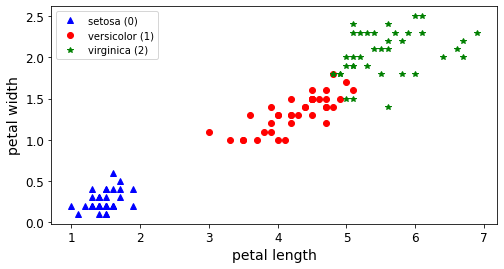

In [5]:
X = iris.data[:, 2:] # selected features, petal-length, -width
y = iris.target
# add bias
Xb = np.c_[np.ones((X.shape[0], 1)), X] # add bias (X0) with ones
print("---Shapes---")
print(f"Xb:      {Xb.shape}\ty:     {y.shape}")

# split data to train, validation, test sets
test_ratio = 0.2
n_samples = len(X)

test_size  = int(n_samples * test_ratio)

np.random.seed(42) # for reproducibility

# random indexes for splitting
rnd_idx = np.random.permutation(n_samples)

Xb_train = Xb[rnd_idx[:-test_size]]
Xb_test  = Xb[rnd_idx[-test_size:]]

y_train = y[rnd_idx[:-test_size]]
y_test  = y[rnd_idx[-test_size:]]

print(f"Xb_train: {Xb_train.shape}\ty_train: {y_train.shape}")
print(f"Xb_test: {Xb_test.shape}\ty_test: {y_test.shape}")

# plot training data
plotData(Xb_train, y_train) # visualize data

In [6]:
# convert targets to OneHot classes
Y_train_OneHot = myOneHot(y_train)
# check if it works as intended
print(f"\ny_train: {y_train[:3]}")
print(f"Y_train_OneHot:\n{Y_train_OneHot[:3]}")

Y_test_OneHot = myOneHot(y_test)


y_train: [1 0 2]
Y_train_OneHot:
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


Conversion of targets to OneHot matrix seems to work as intended.

CPU times: user 294 ms, sys: 12.4 ms, total: 306 ms
Wall time: 300 ms


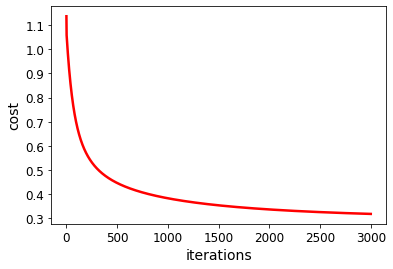

In [7]:
model = myMultiNomLogRegr(lr=0.1, reg=0.02)
%time model.gradient_descent(Xb_train, Y_train_OneHot, iters=3000)

# access optimized parameters
costs, theta = model.costs, model.theta
#print(f"\noptimized theta:\n{theta}")

plotCostHistory(costs)

### Plot of model's predictions

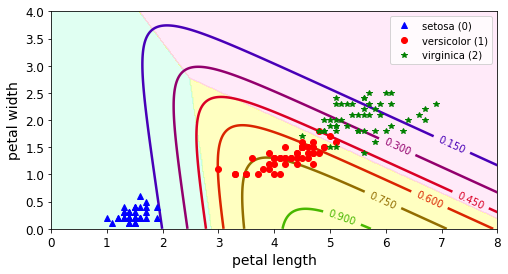

In [8]:
# prepare plot data
x0, x1 = np.meshgrid(
            np.linspace(0, 8, 500).reshape(-1, 1),
            np.linspace(0, 4, 250).reshape(-1, 1),
)

# X for predictions with flattened meshgrid
Xp = np.c_[x0.ravel(), x1.ravel()]
Xpb = np.c_[np.ones(shape=[len(Xp), 1]), Xp] # with bias

# predicted probabilities (column 1 acts as decision boundary)
zz0 = model.predict_prob(Xpb)[:,1].reshape(x0.shape)
# predicted classes
zz1 = model.predict(Xpb).reshape(x0.shape)

# plot predictions
plotData(X, y) # position all data on the plot

myCmap = ListedColormap(['#b3ffe0', '#ffff66','#ffccf2'])
plt.contourf(x0, x1, zz1, alpha=0.4,cmap=myCmap)
contour = plt.contour(x0, x1, zz0, cmap=plt.cm.brg)
plt.clabel(contour, inline=1);

### Evaluate metrics on the test set

In [9]:
accuracy = np.mean(model.predict(Xb_test) == y_test)
print(f"accuracy: {accuracy:.3f}")

accuracy: 0.967


### Comparing against Softmax Regression from scikit-learn

In [10]:
from sklearn.linear_model import LogisticRegression

sklearn_sr = LogisticRegression(multi_class="multinomial",
                                solver="lbfgs",
                                C=10, 
                                random_state=42)

%time sklearn_sr.fit(Xb_train, y_train)

accuracy_reference = sklearn_sr.score(Xb_test, y_test)
print(f"\nsklearn model accuracy: {accuracy_reference:.3f}")

CPU times: user 20.5 ms, sys: 177 µs, total: 20.7 ms
Wall time: 20.8 ms

sklearn model accuracy: 0.967


Although the above logistic regressor performed resonably compared to the sklearn model in this exercise, sklearn is clearly the recommended, preferred, and robost model with many options and flexibilities.